In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import re
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix, roc_auc_score, roc_curve
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from datasets import Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F


In [ ]:
# Load and label data
true_df = pd.read_csv("../data/True.csv")
fake_df = pd.read_csv("../data/Fake.csv")
true_df["label"] = 0  
fake_df["label"] = 1  
df = pd.concat([true_df, fake_df], axis=0).reset_index(drop=True)
text_column = "text" if "text" in df.columns else df.columns[0]


In [ ]:
# Clean text
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    return text

df[text_column] = df[text_column].apply(clean_text)

# Train/Test Split
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=42)


In [ ]:
# Class Weights
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_weights = compute_class_weight(class_weight="balanced", classes=np.array([0, 1]), y=train_df["label"].values)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Tokenization
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
train_encodings = tokenizer(train_df[text_column].tolist(), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(test_df[text_column].tolist(), truncation=True, padding=True, max_length=128)

train_dataset = Dataset.from_dict({
    "input_ids": train_encodings["input_ids"],
    "attention_mask": train_encodings["attention_mask"],
    "labels": train_df["label"].tolist()
})
test_dataset = Dataset.from_dict({
    "input_ids": test_encodings["input_ids"],
    "attention_mask": test_encodings["attention_mask"],
    "labels": test_df["label"].tolist()
})


In [ ]:
# Load BERT model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.to(device)

#Custom Trainer
class WeightedLossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels").to(device)
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fn = nn.CrossEntropyLoss(weight=class_weights)
        loss = loss_fn(logits, labels)
        return (loss, outputs) if return_outputs else loss


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    learning_rate=3e-5,
    logging_steps=50,
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False
)

trainer = WeightedLossTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=lambda pred: {
        "accuracy": accuracy_score(pred.label_ids, pred.predictions.argmax(-1)),
        "f1": precision_recall_fscore_support(pred.label_ids, pred.predictions.argmax(-1), average='binary')[2],
        "precision": precision_recall_fscore_support(pred.label_ids, pred.predictions.argmax(-1), average='binary')[0],
        "recall": precision_recall_fscore_support(pred.label_ids, pred.predictions.argmax(-1), average='binary')[1],
    },
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

# Train the model
trainer.train()


/common/home/projectgrps/IS424/IS424G4/jupyterlab-venv-pytorch-240/lib/python3.11/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.000100,0.008050,0.998664,0.998723,0.997874,0.999574
2,0.000100,0.003784,0.999555,0.999574,0.999787,0.999361
3,0.000000,0.006635,0.999109,0.999148,0.999787,0.998509


TrainOutput(global_step=6735, training_loss=0.007666943294726279, metrics={'train_runtime': 758.9667, 'train_samples_per_second': 141.975, 'train_steps_per_second': 8.874, 'total_flos': 7087817164815360.0, 'train_loss': 0.007666943294726279, 'epoch': 3.0})

In [ ]:
#Save model & tokenizer
#model.save_pretrained("./source_based_bert_saved_trainingmodel")
#tokenizer.save_pretrained("./source_based_bert_saved_trainingmodel")


('./source_based_bert_saved_trainingmodel/tokenizer_config.json',
 './source_based_bert_saved_trainingmodel/special_tokens_map.json',
 './source_based_bert_saved_trainingmodel/vocab.txt',
 './source_based_bert_saved_trainingmodel/added_tokens.json')


📊 Classification Report:
              precision    recall  f1-score   support

        Real   0.999300  0.999767  0.999533      4284
        Fake   0.999787  0.999361  0.999574      4696

    accuracy                       0.999555      8980
   macro avg   0.999544  0.999564  0.999554      8980
weighted avg   0.999555  0.999555  0.999555      8980


📐 ROC AUC Score: 0.999622

🧮 Confusion Matrix:
[[4283    1]
 [   3 4693]]


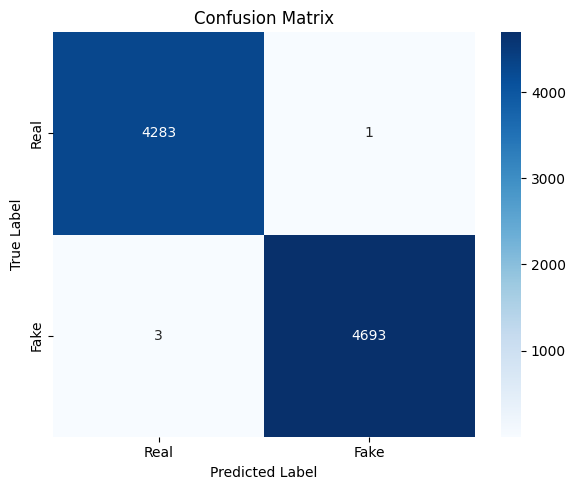

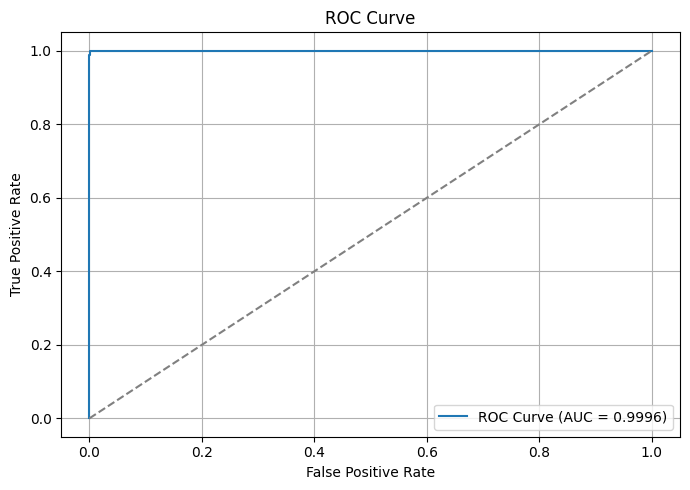

In [ ]:
# Predict on test set
predictions = trainer.predict(test_dataset)
y_true = predictions.label_ids
y_pred = predictions.predictions.argmax(-1)

# Get predicted probabilities for class 1 (Fake = 1)
probs = torch.softmax(torch.tensor(predictions.predictions), dim=1).numpy()
y_probs = probs[:, 1]

# ROC AUC Score
roc_auc = roc_auc_score(y_true, y_probs)

#  Classification Report
print("\n Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Real", "Fake"], digits=6))  
print(f"\n ROC AUC Score: {roc_auc:.6f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print("\n Confusion Matrix:")
print(cm)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Real", "Fake"],  
            yticklabels=["Real", "Fake"])  
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_probs)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# !pip install nltk


In [10]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import re
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix, roc_auc_score, roc_curve
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from datasets import Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
import nltk
from nltk.corpus import stopwords
from collections import Counter


In [ ]:
# Load datasets
true_df = pd.read_csv("../data/True.csv")
fake_df = pd.read_csv("../data/Fake.csv")
true_df["label"] = 0
fake_df["label"] = 1
df = pd.concat([true_df, fake_df], axis=0).reset_index(drop=True)
text_column = "text" if "text" in df.columns else df.columns[0]


In [ ]:
# lean text
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    return text

df[text_column] = df[text_column].apply(clean_text)

# Remove the word "reuters"
def remove_reuters(text):
    return " ".join([word for word in text.split() if word != "reuters"])

df[text_column] = df[text_column].apply(remove_reuters)

# Train/Test Split
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=42)


In [ ]:
# Class Weights
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_weights = compute_class_weight(class_weight="balanced", classes=np.array([0, 1]), y=train_df["label"].values)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Tokenization
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
train_encodings = tokenizer(train_df[text_column].tolist(), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(test_df[text_column].tolist(), truncation=True, padding=True, max_length=128)

train_dataset = Dataset.from_dict({
    "input_ids": train_encodings["input_ids"],
    "attention_mask": train_encodings["attention_mask"],
    "labels": train_df["label"].tolist()
})
test_dataset = Dataset.from_dict({
    "input_ids": test_encodings["input_ids"],
    "attention_mask": test_encodings["attention_mask"],
    "labels": test_df["label"].tolist()
})


In [ ]:
# Load BERT model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.to(device)

# Custom Trainer
class WeightedLossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels").to(device)
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fn = nn.CrossEntropyLoss(weight=class_weights)
        loss = loss_fn(logits, labels)
        return (loss, outputs) if return_outputs else loss


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Training arguments
training_args = TrainingArguments(
    output_dir="./results_removed_topword",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    learning_rate=3e-5,
    logging_steps=50,
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False
)

trainer = WeightedLossTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=lambda pred: {
        "accuracy": accuracy_score(pred.label_ids, pred.predictions.argmax(-1)),
        "f1": precision_recall_fscore_support(pred.label_ids, pred.predictions.argmax(-1), average='binary')[2],
        "precision": precision_recall_fscore_support(pred.label_ids, pred.predictions.argmax(-1), average='binary')[0],
        "recall": precision_recall_fscore_support(pred.label_ids, pred.predictions.argmax(-1), average='binary')[1],
    },
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

# Train the model
trainer.train()


/common/home/projectgrps/IS424/IS424G4/jupyterlab-venv-pytorch-240/lib/python3.11/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.011500,0.012452,0.997439,0.997553,0.996599,0.998509
2,0.000000,0.012505,0.997884,0.997978,0.997447,0.998509
3,0.000200,0.012817,0.998218,0.998296,0.998509,0.998083


TrainOutput(global_step=6735, training_loss=0.014865845134964042, metrics={'train_runtime': 759.5822, 'train_samples_per_second': 141.86, 'train_steps_per_second': 8.867, 'total_flos': 7087817164815360.0, 'train_loss': 0.014865845134964042, 'epoch': 3.0})

In [ ]:
# Save model & tokenizer
model.save_pretrained("./source_based_bert_saved_trainingmodel2")
tokenizer.save_pretrained("./source_based_bert_saved_trainingmodel")


('./source_based_bert_saved_trainingmodel/tokenizer_config.json',
 './source_based_bert_saved_trainingmodel/special_tokens_map.json',
 './source_based_bert_saved_trainingmodel/vocab.txt',
 './source_based_bert_saved_trainingmodel/added_tokens.json')


📊 Classification Report:
              precision    recall  f1-score   support

        Real   0.998363  0.996265  0.997313      4284
        Fake   0.996599  0.998509  0.997553      4696

    accuracy                       0.997439      8980
   macro avg   0.997481  0.997387  0.997433      8980
weighted avg   0.997441  0.997439  0.997439      8980


📐 ROC AUC Score: 0.999599

🧮 Confusion Matrix:
[[4268   16]
 [   7 4689]]


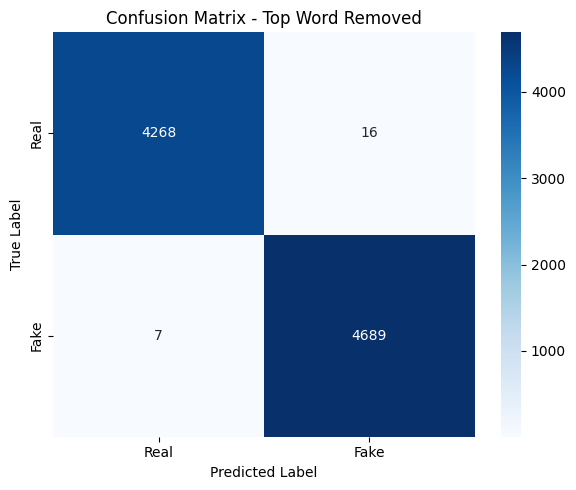

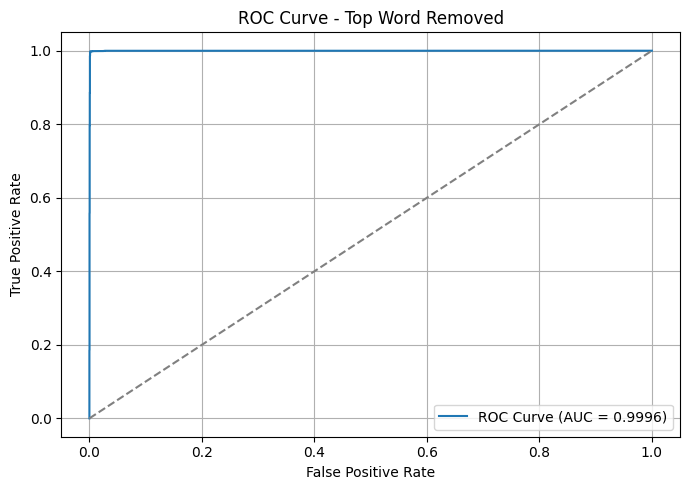

In [ ]:
# Predict
predictions = trainer.predict(test_dataset)
y_true = predictions.label_ids
y_pred = predictions.predictions.argmax(-1)

# Get predicted probabilities
probs = torch.softmax(torch.tensor(predictions.predictions), dim=1).numpy()
y_probs = probs[:, 1]  # Probability for class 1 (Fake)

# ROC AUC Score
roc_auc = roc_auc_score(y_true, y_probs)

# Reports
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["Real", "Fake"], digits=6))
print(f"\nROC AUC Score: {roc_auc:.6f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(cm)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Real", "Fake"], 
            yticklabels=["Real", "Fake"])  
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Top Word Removed")
plt.tight_layout()
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_probs)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Top Word Removed")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()
